### ROC 曲線

受信者操作特性（Receiver Operating Characteristic: ROC）曲線
- 性能に基づいて分類モデルを選択するためのツール
- 分類器のしきい値を変えることによって計算される偽陽性（FP）率と真陽性（TP）率が選択の基準になる
  - しきい値 = 1：原点に対応  
  - しきい値 = 0：(1, 1) に対応
- 横軸が偽陽性率、縦軸が真陽性率にプロット
- ROC曲線の対角線は当て推量（ランダムな推量）として解釈でき、対角線を下回るモデルは当て推量よりも劣るとみなせる
  - 当て推量：すべて0または1と出力したときの ROC 曲線
- 分類モデルの性能は、ROC曲線に基づいた曲線下面積（AUC: Area under the curve）で評価できる。

### AUC 
- ROC 曲線の下の面積
- 分類機の性能の評価指標
  - 1 に近いほど性能がいい（最大の面積が1になるため）

### 評価指標の使い分け
- Precision: TPが少なくともFPを少なくしたい
- Recall: FPの数に関わらず、Pをもれなく予測したい
- Accuracy: 上記の狙いはないとき
- AUC: 上記のねらいはなく、クラスが不均衡なとき


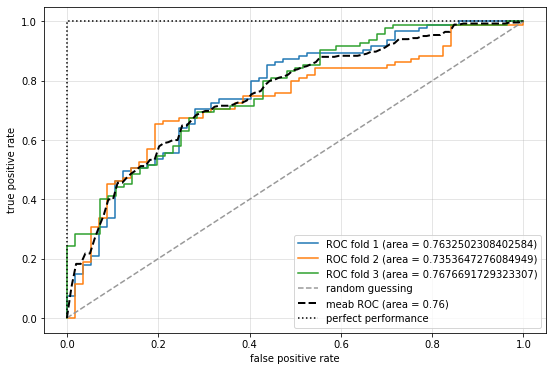

In [1]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.datasets import load_breast_cancer
from sklearn.pipeline import make_pipeline
# from scipy import interp
import matplotlib.pyplot as plt
import numpy as np 

# Init
fig = plt.figure(figsize=(9, 6))

# Load data
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train2 = X_train[:, [4, 14]]
cv = list(StratifiedKFold(n_splits=3,  random_state=1, shuffle=True).split(X_train, y_train))

# Make pipeline
pipeline_lr = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    LogisticRegression(penalty='l2', random_state=1, C=100.0)
)


mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate(cv):
    probabilities = pipeline_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probabilities[:, 1], pos_label=1)
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC fold {} (area = {})'.format(i+1, roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='meab ROC (area = {:.2f})'.format(mean_auc), lw=2)

plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid(alpha=0.4)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc='lower right')
plt.show()

### 他クラス分類までの評価指標

他クラスの場合でも一括でわかる指標を定義
- マイクロ平均: 予測お平等に重みづけたいときに使用
- マクロ平均: クラス間を平等に重みづけたいときに使用

### クラスの不均衡

対策
- 少数はクラスの誤予測に対してペナルティをつける
- 少ないデータのアップサンプリング（データの複製）
- 多いデータのダウンサンプリング（データの抽出）
  - 固まった分布を抽出すると過学習を起こしてしまうので、広い分布を選択することが必要